# Env instructions

```bash
conda create -n 202108-pykaldi-c11 python=3.7
conda activate 202108-pykaldi-c11
conda install mamba -c conda-forge
mamba install pytorch torchvision torchaudio cudatoolkit=11.0 pykaldi matplotlib tqdm ipython scipy psutil progressbar ptvsd requests cython patchelf graphviz jupyterlab unidecode sentencepiece numba -c conda-forge -c pytorch -c pykaldi
pip install git+https://github.com/jpuigcerver/openfst-python.git
```

In [31]:
import io
from collections import defaultdict, namedtuple, Counter

import unidecode

import numpy as np
from scipy.special import logsumexp, digamma

import kaldi.fstext as fst
# import openfst_python as fst
import sentencepiece as spm

from kaldi_fst_sp import *

In [32]:
# TEXT = open('botchan.txt').read()

TEXT='abababaabb cacacacacacacaca acacacacacac ca caca cacaca ac acac acacac abcabcabcabcabcab'
TEXT='abababaabb abcabcabcabcabcab ac acac acacac acacacacacac ca caca cacaca cacacacacacacaca'

TEXT = unidecode.unidecode(TEXT.lower())  #.replace(' ', '')
SENTENCES_BY_SPACE = [Sentence(text, count) for text, count in Counter(TEXT.split()).items()]
SENTENCES = [Sentence(line.strip(), 1) for line in TEXT.split('\n') if line.strip()]
TEXT = '\n'.join([s[0] for s in SENTENCES])

In [33]:
# Get the reference sentencpieces
model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=8, 
    shrinking_factor=0.85,
    shuffle_input_sentence=0,
    num_sub_iterations=10
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 8
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 0
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.85
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 10
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [34]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
FINAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in FINAL_PIECES if piece.log_freq != 0.0]))}")
FINAL_PIECES[:100]

Tot unigram prob: 0.8163016306690613


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [35]:
# Get the initial vocab

model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=10,
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 10
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [36]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
INITIAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in INITIAL_PIECES if piece.log_freq != 0.0]))}")
INITIAL_PIECES[:100]

Tot unigram prob: 0.8261814959746875


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.5813193321228027),
 SentencePiece(index=4, symbol='ab', log_freq=-1.9380321502685547),
 SentencePiece(index=5, symbol='▁acacac', log_freq=-3.227902412414551),
 SentencePiece(index=6, symbol='▁cacaca', log_freq=-3.227902412414551),
 SentencePiece(index=7, symbol='▁', log_freq=-4.227703094482422),
 SentencePiece(index=8, symbol='c', log_freq=-4.227802753448486),
 SentencePiece(index=9, symbol='a', log_freq=-4.227902889251709)]

In [37]:
import importlib
import kaldi_fst_sp
importlib.reload(kaldi_fst_sp)
from kaldi_fst_sp import *

In [38]:
T = SentencePieceTrainer(INITIAL_PIECES)
# T = SentencePieceTrainer(FINAL_PIECES)

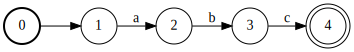

In [39]:
T.text_to_fst('abc')

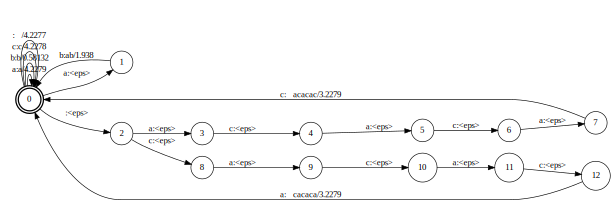

In [40]:
sp_to_chr = T.get_sp_to_char(INITIAL_PIECES, arc_type='log')
sp_to_chr

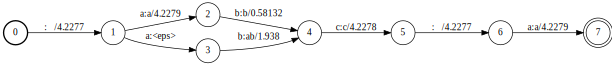

In [41]:
sentence = 'abc a'
# sentence = SENTENCES_BY_SPACE[3][0]
lattice = T.get_lattice_naive(sentence, T.get_sp_to_char(INITIAL_PIECES))
lattice

In [42]:
T.compute_piece_counts_naive(sentence, T.get_sp_to_char(INITIAL_PIECES))

PieceCounts(Z=18.794057846069336, counts=defaultdict(<class 'float'>, {7: 2.000000476837272, 9: 1.0535966996228223, 3: 0.05359622278555041, 4: 0.9464036251483268, 8: 0.9999995231629555}))

In [43]:
T.viterbi_naive(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)

[ViterbiPath(path=[7, 4, 8, 7, 9], prob=0.9464036251483268),
 ViterbiPath(path=[7, 9, 3, 8, 7, 9], prob=0.053596248342227065)]

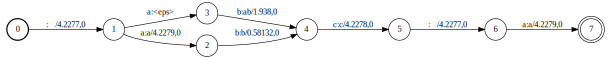

In [44]:
lattice = T.get_lattice(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'))
lattice

In [45]:
T.compute_piece_counts(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'))

PieceCounts(Z=18.794057846069336, counts=defaultdict(<class 'float'>, {7: 2.000000476837272, 9: 1.0535966996228223, 3: 0.05359622278555041, 4: 0.9464036251483268, 8: 0.9999995231629555}))

In [46]:
T.viterbi(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)

[ViterbiPath(path=[7, 4, 8, 7, 9], prob=0.9464036251483268),
 ViterbiPath(path=[7, 9, 3, 8, 7, 9], prob=0.053596248342227065)]

In [47]:
# TODO: verify why EM returns different results, when our Viterbi seems to be OK
assert len(sp.tokenize(SENTENCES[0][0])) == len(T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
print(list(zip(sp.tokenize(SENTENCES[0][0]), T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(7, 7), (4, 4), (4, 4), (4, 4), (9, 9), (4, 4), (3, 3), (7, 7), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (7, 7), (9, 9), (8, 8), (7, 7), (9, 9), (8, 8), (9, 9), (8, 8), (5, 5), (5, 5), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (7, 7), (8, 8), (9, 9), (7, 7), (8, 8), (9, 9), (8, 8), (9, 9), (6, 6), (6, 6), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9)]


In [48]:
for S, _ in SENTENCES_BY_SPACE[:10]:
    assert len(sp.tokenize(S)) == len(T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
    print(list(zip(sp.tokenize(S), T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(7, 7), (4, 4), (4, 4), (4, 4), (9, 9), (4, 4), (3, 3)]
[(7, 7), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4)]
[(7, 7), (9, 9), (8, 8)]
[(7, 7), (9, 9), (8, 8), (9, 9), (8, 8)]
[(5, 5)]
[(5, 5), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8)]
[(7, 7), (8, 8), (9, 9)]
[(7, 7), (8, 8), (9, 9), (8, 8), (9, 9)]
[(6, 6)]
[(6, 6), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9)]


In [49]:
# Sentencepiece training
pieces = INITIAL_PIECES
pieces = [SentencePiece(index=3, symbol="a", log_freq=-3.865555), SentencePiece(index=4, symbol="c", log_freq=-4.042485), SentencePiece(index=5, symbol="b", log_freq=-5.078577), SentencePiece(index=6, symbol="▁", log_freq=-5.173887), SentencePiece(index=7, symbol="acacac", log_freq=-3.382128), SentencePiece(index=8, symbol="acaca", log_freq=-3.382128), SentencePiece(index=9, symbol="acac", log_freq=-3.382128), SentencePiece(index=10, symbol="cacaca", log_freq=-3.382128), SentencePiece(index=11, symbol="cacac", log_freq=-3.382128), SentencePiece(index=12, symbol="caca", log_freq=-3.382128), SentencePiece(index=13, symbol="acacacac", log_freq=-3.451121), SentencePiece(index=14, symbol="acacaca", log_freq=-3.451121), SentencePiece(index=15, symbol="cacacaca", log_freq=-3.451121), SentencePiece(index=16, symbol="cacacac", log_freq=-3.451121), SentencePiece(index=17, symbol="acacacaca", log_freq=-3.487488), SentencePiece(index=18, symbol="aca", log_freq=-3.487488), SentencePiece(index=19, symbol="cacacacac", log_freq=-3.487488), SentencePiece(index=20, symbol="cac", log_freq=-3.487488), SentencePiece(index=21, symbol="ca", log_freq=-3.487488), SentencePiece(index=22, symbol="acacacacac", log_freq=-3.564449), SentencePiece(index=23, symbol="cacacacaca", log_freq=-3.564449), SentencePiece(index=24, symbol="acacacacaca", log_freq=-3.692283), SentencePiece(index=25, symbol="ac", log_freq=-3.692283), SentencePiece(index=26, symbol="cacacacacac", log_freq=-3.692283), SentencePiece(index=27, symbol="acacacacacac", log_freq=-3.892953), SentencePiece(index=28, symbol="cacacacacaca", log_freq=-3.892953), SentencePiece(index=29, symbol="abcabcabcab", log_freq=-3.979965), SentencePiece(index=30, symbol="abcabcab", log_freq=-4.010736), SentencePiece(index=31, symbol="bcabcabcab", log_freq=-4.075275), SentencePiece(index=32, symbol="abcabcabcabcab", log_freq=-4.144268), SentencePiece(index=33, symbol="bcabcab", log_freq=-4.144268), SentencePiece(index=34, symbol="cacacacacacaca", log_freq=-4.144268), SentencePiece(index=35, symbol="cabcabcab", log_freq=-4.180635), SentencePiece(index=36, symbol="acacacacacaca", log_freq=-4.218376), SentencePiece(index=37, symbol="bcabcabcabcab", log_freq=-4.218376), SentencePiece(index=38, symbol="abcab", log_freq=-4.257596), SentencePiece(index=39, symbol="cabcabcabcab", log_freq=-4.298419), SentencePiece(index=40, symbol="cabcab", log_freq=-4.298419), SentencePiece(index=41, symbol="ab", log_freq=-4.480740), SentencePiece(index=42, symbol="bcab", log_freq=-4.480740), SentencePiece(index=43, symbol="cab", log_freq=-4.768422), SentencePiece(index=44, symbol="▁acac", log_freq=-4.768422), SentencePiece(index=45, symbol="▁caca", log_freq=-4.768422), SentencePiece(index=46, symbol="▁acacac", log_freq=-4.837415), SentencePiece(index=47, symbol="▁cacaca", log_freq=-4.837415), SentencePiece(index=48, symbol="▁ac", log_freq=-4.991566), SentencePiece(index=49, symbol="▁a", log_freq=-4.991566), SentencePiece(index=50, symbol="▁ca", log_freq=-4.991566), SentencePiece(index=51, symbol="ababa", log_freq=-5.173887), SentencePiece(index=52, symbol="aba", log_freq=-5.279248), SentencePiece(index=53, symbol="baba", log_freq=-5.397031), SentencePiece(index=54, symbol="ba", log_freq=-5.684713), SentencePiece(index=55, symbol="▁ab", log_freq=-5.684713)]
sentences = SENTENCES_BY_SPACE

DESIRED_PIECES = 5
PRUNE_FRAC = 0.85
NUM_SUBITER = 10

while True:
    # EM Step
    for sub_iter in range(NUM_SUBITER):  # num_sub_iterations
#         print("\n".join(map(str, pieces)))
        e_ret = T.EStep(pieces, sentences)
        
        pieces = T.MStep(pieces, e_ret.counts)
        print(f"EM sub_iter={sub_iter} size={len(pieces)} tot_piece_prob={np.exp(logsumexp([piece.log_freq for piece in pieces]))} "
              f"obj={e_ret.objective} num_tokens={e_ret.n_tokens} num_tokens/piece={e_ret.n_tokens / len(pieces)}" )
    
    if len(pieces) <= DESIRED_PIECES:
        break

#     print("\n".join(map(str, pieces)) + '\n')
    pieces = T.prune_pieces(pieces, sentences, DESIRED_PIECES, PRUNE_FRAC)
#     print("\n".join(map(str, pieces)))
    if len(pieces) <= DESIRED_PIECES:
        break
        
# TODO: add finalization

EM sub_iter=0 size=14 tot_piece_prob=0.7187162330716661 obj=7.393380832672119 num_tokens=17 num_tokens/piece=1.2142857142857142
EM sub_iter=1 size=13 tot_piece_prob=2.0314847269695666 obj=28.879104495048523 num_tokens=39 num_tokens/piece=3.0
EM sub_iter=2 size=12 tot_piece_prob=3.2883543242356077 obj=4.850144910812378 num_tokens=41 num_tokens/piece=3.4166666666666665
EM sub_iter=3 size=12 tot_piece_prob=3.4546042955637675 obj=4.217644619941711 num_tokens=41 num_tokens/piece=3.4166666666666665
EM sub_iter=4 size=12 tot_piece_prob=3.685443803671188 obj=3.8463905811309815 num_tokens=45 num_tokens/piece=3.75
EM sub_iter=5 size=10 tot_piece_prob=4.192867893668024 obj=3.3277851581573485 num_tokens=61 num_tokens/piece=6.1
EM sub_iter=6 size=8 tot_piece_prob=4.712837176691308 obj=2.199039700627327 num_tokens=61 num_tokens/piece=7.625
EM sub_iter=7 size=8 tot_piece_prob=5.019463833306406 obj=1.1381250619888306 num_tokens=61 num_tokens/piece=7.625


ERROR:root:State id -1 not valid


EM sub_iter=8 size=8 tot_piece_prob=5.44536916979087 obj=0.5691704988479614 num_tokens=61 num_tokens/piece=7.625
EM sub_iter=9 size=8 tot_piece_prob=6.071337919591415 obj=-0.17064603567123413 num_tokens=69 num_tokens/piece=8.625


IndexError: State index out of range

In [50]:
FINAL_PIECES

[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [51]:
pieces

[SentencePiece(index=3, symbol='a', log_freq=0.6478899231436386),
 SentencePiece(index=4, symbol='c', log_freq=0.5986057147433228),
 SentencePiece(index=5, symbol='b', log_freq=-0.7843604578442953),
 SentencePiece(index=6, symbol='▁', log_freq=0.0),
 SentencePiece(index=41, symbol='ab', log_freq=-1.647753876581664),
 SentencePiece(index=48, symbol='▁ac', log_freq=-1.2588741736036968),
 SentencePiece(index=50, symbol='▁ca', log_freq=-1.2588741736036968),
 SentencePiece(index=55, symbol='▁ab', log_freq=-2.0922076176534947)]